In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file_path = 'zameen.csv'
house_data = pd.read_csv(file_path)

In [3]:
# Function to convert area to marlas
def convert_to_marlas(area_str):
    try:
        area_str = str(area_str).replace(',', '').lower().strip()
        if 'kanal' in area_str:
            area_value = float(area_str.split()[0])
            return area_value * 20  # 1 kanal = 20 marlas
        elif 'marla' in area_str:
            return float(area_str.split()[0])
        else:
            return float(area_str)
    except ValueError:
        return np.nan  # Return NaN for any problematic values

In [4]:
# Apply the conversion function to the 'area' column
house_data['area'] = house_data['area'].apply(convert_to_marlas)

In [5]:
# Drop rows with missing values
house_data.dropna(subset=['area', 'bedrooms', 'baths', 'price'], inplace=True)

In [6]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
    return df.loc[filter]

house_data = remove_outliers(house_data, 'price')
house_data = remove_outliers(house_data, 'area')

In [7]:
# Select relevant features and target variable
features = ['area', 'bedrooms', 'baths']
target = 'price'

In [8]:
# Separate the features (X) from the target variable (y)
X = house_data[features]
y = house_data[target]


In [9]:
# Log transformation of the target variable to reduce skewness
y_log = np.log1p(y)

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)


In [11]:
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [12]:
# Make predictions on the test set
y_pred_log = grid_search.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert predictions back to the original scale


In [13]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_log)
mse = mean_squared_error(y_test, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_log)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)


Mean Absolute Error (MAE): 0.2966500013447025
Mean Squared Error (MSE): 0.1920206562969492
Root Mean Squared Error (RMSE): 0.4382016160364418
R-squared (R²): 0.6631561382280047


In [15]:
# Example of predicting the house price for a new data point
area_marlas = float(input("Enter the area of the house in marlas: "))
bedrooms = int(input("Enter the number of bedrooms: "))
baths = int(input("Enter the number of bathrooms: "))

new_data = pd.DataFrame({
    'area': [area_marlas],
    'bedrooms': [bedrooms],
    'baths': [baths]
})

# Create polynomial features for new data
new_data_poly = poly.transform(new_data)

# Scale the new data point
new_data_scaled = scaler.transform(new_data_poly)

# Predict the price for the new data point
predicted_price_log = grid_search.best_estimator_.predict(new_data_scaled)
predicted_price = np.expm1(predicted_price_log)  # Convert prediction back to original scale
print("Predicted Price for the new data point in PKR:", predicted_price[0])


Enter the area of the house in marlas: 7
Enter the number of bedrooms: 4
Enter the number of bathrooms: 3
Predicted Price for the new data point in PKR: 10203669.0


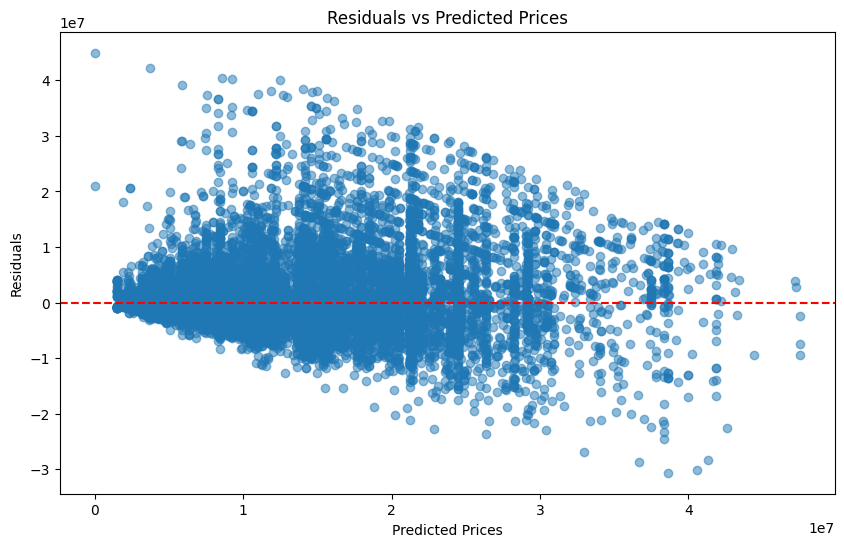

In [20]:

# Plot residuals
residuals = np.expm1(y_test) - np.expm1(y_pred_log)
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_pred_log), residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()


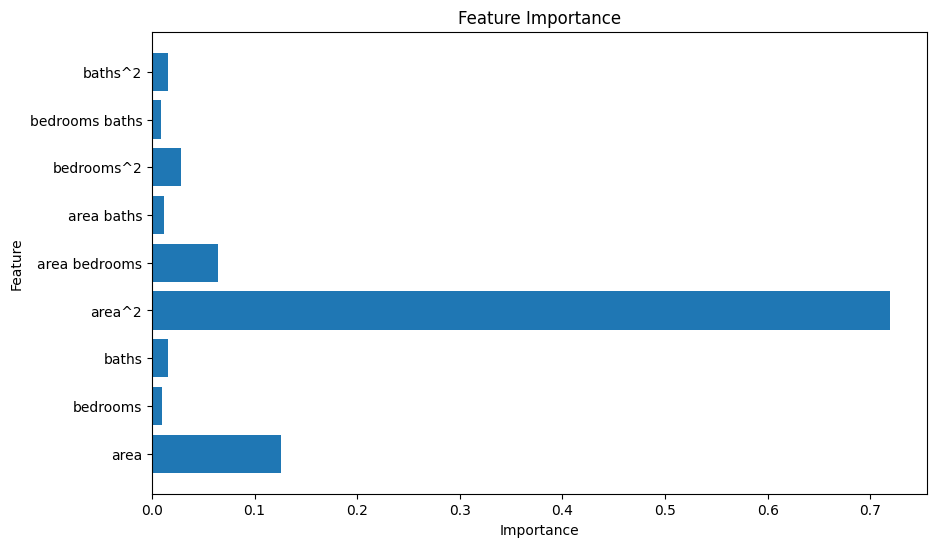

In [21]:
importances = grid_search.best_estimator_.feature_importances_
feature_names = poly.get_feature_names_out(input_features=features)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


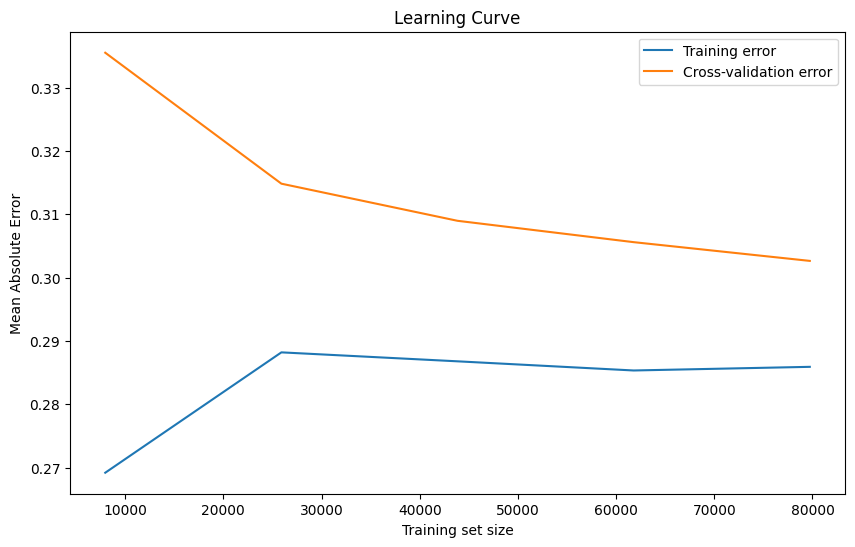

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_scaled, y_log, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


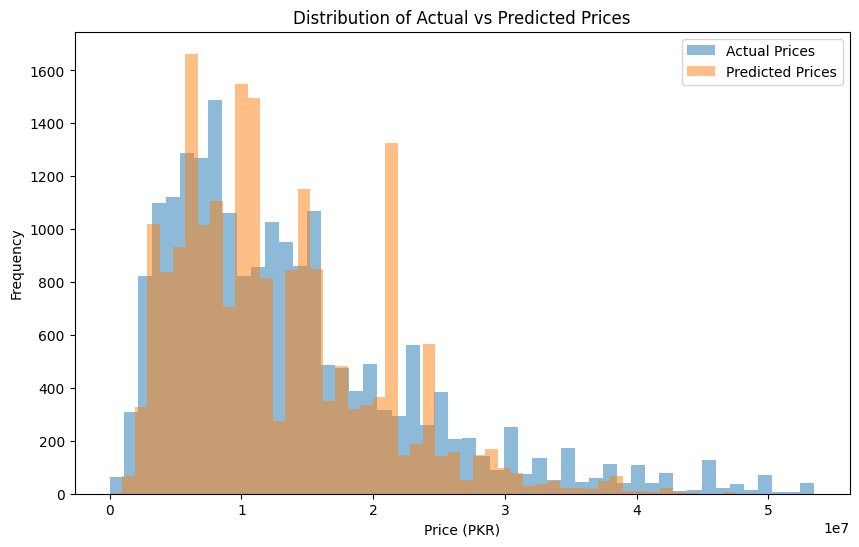

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(np.expm1(y_test), bins=50, alpha=0.5, label='Actual Prices')
plt.hist(np.expm1(y_pred_log), bins=50, alpha=0.5, label='Predicted Prices')
plt.xlabel('Price (PKR)')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted Prices')
plt.legend()
plt.show()


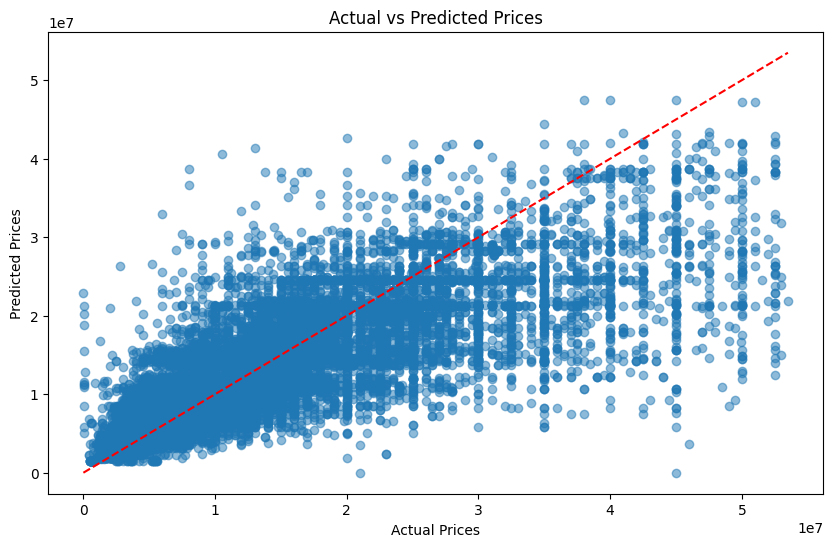

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_log), alpha=0.5)
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()
